<a href="https://colab.research.google.com/github/friedelj/AAI-510-TEAM-03/blob/main/JFriedel_CV_Assignment6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment 6 Exercise: GAN Model

**Part 1- Digit generator**

Part 1- Number generator
For the first part of this lab, we want to use GAN to create handwritten numbers from 0 to 9. For this
propose, we will use tensorflow to create the model from scratch. Although there are many already
developed models which can create these digits, the purpose of this assignment is learning the steps. In
this section you will create it yourself.

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import time
from IPython import display

In [3]:
#a- Reading data

# Load the MNIST dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Reshape the images to have a channel dimension and cast to float32
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

In [5]:
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5

In [6]:
# Define buffer and batch size for training
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Create a TensorFlow data pipeline
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [8]:
print(f"Dataset prepared: {train_dataset}")

Dataset prepared: <_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>


In [9]:
# Creating the generative model function
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [10]:
# Use the generator model which is not trained yet to create an image
generator = make_generator_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
noise = tf.random.normal([1, 100])  #This creates the noise
generated_image = generator(noise, training=False)

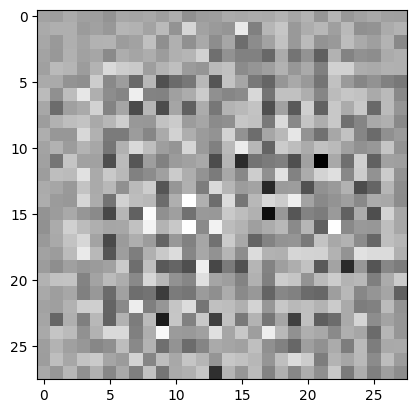

In [12]:
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

# what is this image?

```
The output is a computer-generated grayscale image (28×28 pixels) generated by the make_generator_model. The image looks like the real data because the generator is trained to learn patterns from the MNIST dataset.
```



In [13]:
#c- Create discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
# Applying discriminative model on the untrained image which was the output of generative model
discriminator = make_discriminator_model()# Call discriminator function
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00020608]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cross_entropy

In [16]:
#d- Compute the loss
# Discriminator loss This method quantifies how well the discriminator is able to distinguish real images from fakes.
# It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output) #Same command as above but for fake_output
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
#Generator loss The generator's loss quantifies how well it was able to trick the discriminator.
#Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [19]:
# e- Model design
# Let's save the model for future references
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
# Model parametrs
# EPOCHS = 50
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:
#The training loop begins with generator receiving a random seed as input. That seed is used to produce an image.
#The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator).
#The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [22]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

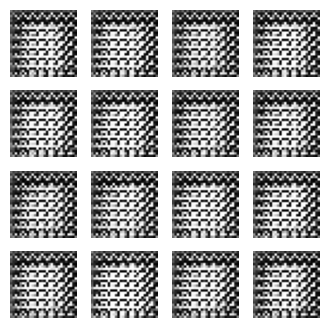

In [29]:
#Call the function in proper way
train(train_dataset, EPOCHS)  #Put appropriate values here and call the function

In [30]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
# You can use these commands to save the evpolution as a GIF file
anim_file = 'GAN_digit.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-31-46e0a5f4e49b>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-31-46e0a5f4e49b>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


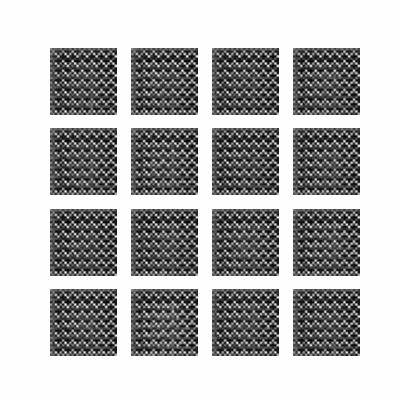

In [32]:
display.Image(filename=anim_file)

# what is your understanding from this GIF file?

I ran a training loop for my GAN on the MNIST dataset and saved the evolution as a GIF file.  Initially the image would look like randon noise, mid-way through the image should have recognizable traits of a digit, like straight lines or loops.  By the final epoch, the GIF should resemble and be identifiable as a handwritten integer, similar to the dataset.  However, the GIF is unrecognizable to me.  The problem could be too few epochs.  I initially ran 50 epochs, overnight, and the loop stopped running after 20.  I dropped the epoch number to 10, and got the results displayed above.  An epoch takes about 12 minutes to ru on my PC, so 50 epochs takes about 10 hours to run.

**Part 2- Pokemon characters and GAN**

The next example is inspired from Intro to Generative Adversarial Networks (GANs) | Towards Data
Science and d2l.ai. The goal of this model is to create the characters of pokemon using a GAN model.
The dataset that we use is from d2l package (d2l · PyPI).

In [1]:
pip install --upgrade google-colab

In [1]:
pip install ipykernel==5.5.6

In [3]:
#Install d2l package
!pip install d2l==1.0.0-alpha1.post0

In [4]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [5]:
#a- Read the dataset and store it
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

# We store the directory in this variable
data_dir = d2l.download_extract('pokemon')
batch_size = 256
# Use preprocessing from Keras to read images from directory using given batch size and map them to 64x64 images
pokemon = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, batch_size=batch_size, image_size=(64, 64))

Found 40597 files belonging to 721 classes.


In [7]:
#Normalize the data between [-1,1]
# We normalize the data with  0.5  mean and  0.5  standard deviation to match the value range
# Write a function to normalize the images by dividing them to 255 and use gaussian normalization with mean of 0.5 and standard deviation of 0.5.
def transform_func(X):
    # Write the function here in which it normalied the X in the way explained above.

    # Normalize images: Scale pixel values from [0, 255] to [-1, 1].

    # Divide by 255 to scale to [0, 1]
    X = X / 255.0
    # Apply Gaussian normalization: scale to [-1, 1]
    X = (X - 0.5) / 0.5
    return X

data_iter = pokemon.map(lambda x, y: (transform_func(x), y),
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

In [8]:
# Apply transformation and create data iterator
data_iter = pokemon.map(
    lambda x, y: (transform_func(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
)
data_iter = data_iter.cache().shuffle(buffer_size=1000).prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

In [9]:
# Test transformation
for images, labels in data_iter.take(1):
    print(f"Batch shape: {images.shape}")
    print(f"Labels: {labels.numpy()[:5]}")

Batch shape: (256, 64, 64, 3)
Labels: [116 265 303 377 680]


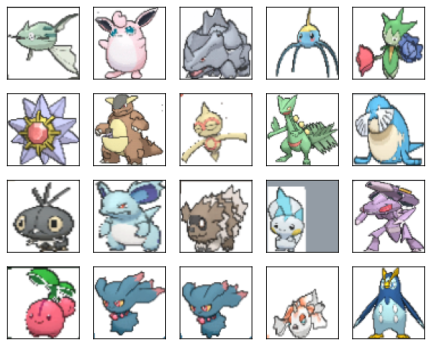

In [10]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

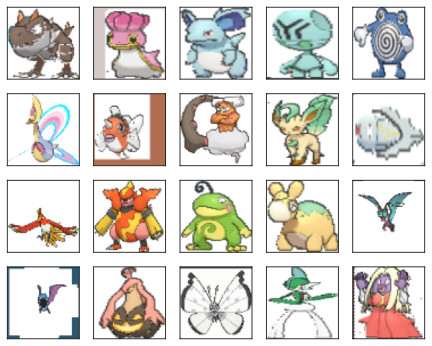

In [39]:
#b- Visualize first 20 images
d2l.set_figsize(figsize=(4, 4))
for X, y in data_iter.take(1):
    imgs = X[:20, :, :, :] / 2 + 0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)

## The Generator

The generator needs to map the noise variable to a RGB image with width and height to be $64\times 64$ .

In [11]:
#c- Creating the generator
class G_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 **kwargs):
        super().__init__(**kwargs)
        self.conv2d_trans = tf.keras.layers.Conv2DTranspose(
            out_channels, kernel_size, strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.ReLU()

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

# Explain your understanding of the G_block here.

The G_block in the above code creates a generator block for a Generative Adversarial Network (GAN), with purpose of creating a high quality image out of random noise.  The Conv2DTranspose layer does a deconvolution, increasing the dimensions of the input tensor.  The input parameters are the number of filters, size of the convolutional kernel, strides and padding.    Batch Nornalization normalizes the transposed convolution output.  The Activation Functions is ReLU.

In [12]:
x = tf.zeros((2, 16, 16, 3))  # Input based on the instruction
#Call the G_block package and use 20 as the number of layers (input of the class)
g_blk = G_block(20)
# Show the dimension of the output
g_blk(x).shape

TensorShape([2, 32, 32, 20])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.

In [13]:
n_G = 64
net_G = tf.keras.Sequential([
    # Output: (4, 4, 64 * 8)
    G_block(out_channels=n_G*8, strides=1, padding="valid"),
    G_block(out_channels=n_G*4), # Output: (8, 8, 64 * 4)
    G_block(out_channels=n_G*2), # Output: (16, 16, 64 * 2)
    G_block(out_channels=n_G), # Output: (32, 32, 64)
    # Output: (64, 64, 3)
    tf.keras.layers.Conv2DTranspose(
        3, kernel_size=4, strides=2, padding="same", use_bias=False,
        activation="tanh")
])

In [14]:
# Generate a 100 dimensional latent variable to verify the generator's output shape.
x = tf.zeros((1, 1, 1, 100))
net_G(x).shape

TensorShape([1, 64, 64, 3])

## Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.

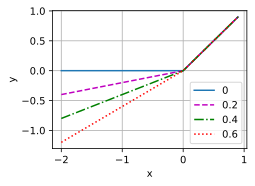

In [15]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

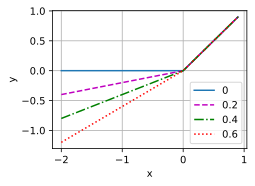

In [44]:
alphas = [0, .2, .4, .6, .8, 1]
x = tf.range(-2, 1, 0.1)
Y = [tf.keras.layers.LeakyReLU(alpha)(x).numpy() for alpha in alphas]
d2l.plot(x.numpy(), Y, 'x', 'y', alphas)

In [16]:
# d- Block of Discriminator
class D_block(tf.keras.layers.Layer):
    def __init__(self, out_channels, kernel_size=4, strides=2, padding="same",
                 alpha=0.2, **kwargs):
        super().__init__(**kwargs)
        self.conv2d = tf.keras.layers.Conv2D(out_channels, kernel_size,
                                             strides, padding, use_bias=False)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.LeakyReLU(alpha)

    def call(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

# Explain your understanding of D_block here.

The D_block creates the discriminator block for the GAN.  The discriminator distinguishes between real and generated data.  The Conv2D layer extracts size features from the input image.  The Batch Normalization layer normalizes the convolution layer activations.  The Leaky ReLU creates non-linearity, solving issues caused by regular ReLU.

In [17]:
x = tf.zeros((2, 16, 16, 3))
#Call the G_block package and use 20 as the number of layers (input of the class)
d_blk = D_block(20)
# Show the dimension of the output
d_blk(x).shape

TensorShape([2, 8, 8, 20])

The discriminator is a mirror of the generator.

In [18]:
n_D = 64
net_D = tf.keras.Sequential([
    D_block(n_D), # Output: (32, 32, 64)
    D_block(out_channels=n_D*2), # Output: (16, 16, 64 * 2)
    D_block(out_channels=n_D*4), # Output: (8, 8, 64 * 4)
    D_block(out_channels=n_D*8), # Outupt: (4, 4, 64 * 64)
    # Output: (1, 1, 1)
    tf.keras.layers.Conv2D(1, kernel_size=4, use_bias=False)
])

In [19]:
#It uses a convolution layer with output channel  1  as the last layer to obtain a single prediction value.
x = tf.zeros((1, 64, 64, 3))
net_D(x).shape

TensorShape([1, 1, 1, 1])

## Training


In [20]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=tf.keras.losses.Reduction.SUM)

    for w in net_D.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))
    for w in net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5, beta_2=0.999)

    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)

    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(mean=0, stddev=1, shape=(batch_size, 1, 1, latent_dim))
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, optimizer_D),
                       d2l.update_G(Z, net_D, net_G, loss, optimizer_G),
                       batch_size)

        Z = tf.random.normal(mean=0, stddev=1, shape=(21, 1, 1, latent_dim))
        fake_x = net_G(Z) / 2 + 0.5
        imgs = tf.concat([tf.concat([fake_x[i * 7 + j] for j in range(7)], axis=1)
                          for i in range(len(fake_x) // 7)], axis=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device._device_name)}')

# Explain your understanding from this model here?

This code creates the training function for the GAN.  It trains both the Net_D discriminator and net_G generator.  The Loss Function gages how well the discriminator differentiates between real and generated data.  The Weight Initialization, initialized to random values from a mormal distribution of SD= 0.2.  The Adam Optimizer reduces oscilations (B1) and deals with the moving average (B2).  The Animator provides real-time visualization of the trening loss.

In [24]:
lr = 0.0002  # Example value for the learning rate
optimizer_hp = {"learning_rate": lr, "beta_1": 0.5, "beta_2": 0.999}
optimizer_D = tf.keras.optimizers.Adam(**optimizer_hp)
optimizer_G = tf.keras.optimizers.Adam(**optimizer_hp)

#We train the model with a small number of epochs just for demonstration. For better performance, the variable num_epochs can be set to a larger number.

In [ ]:
# Call the function
latent_dim, lr, num_epochs = 100, 0.0005, 1
train(net_D=net_D, net_G=net_G, data_iter=data_iter,
      num_epochs=num_epochs, lr=lr, latent_dim=latent_dim)

KeyboardInterrupt: 

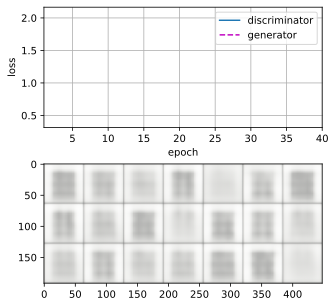

In [59]:
# Call the function
latent_dim, lr, num_epochs = 100, 0.0005, 40
train(net_D=net_D, net_G=net_G, data_iter=data_iter,
      num_epochs=num_epochs, lr=lr, latent_dim=latent_dim)

# what is your understanding from this learning curve?

The learning curve for the GAN training process, shown above as a graph of loss versus epochs, would provide statuss into the training progress of the Generator and Discriminator. It would show loss trends.  For the discriminator, early training loss could change sharpely as the model distinguishes between the real and fake images.  In further training the loss would be expected to stabilize, showing that the discriminator is balanced (not too strong or too weak).  Rapidly dropping loss could suggest a vanishing gradient problem for the generator.  For the generator, the loss is initially high, generating poor quality images.  As training progresses the loss should decrease and the images should improve.  If the loss increases steadily, then that indicates a model problem.

In [64]:
num_epochs=1 #to speed up execution
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim, device=d2l.try_gpu()):
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Weight Initialization
    for w in net_D.trainable_variables + net_G.trainable_variables:
        w.assign(tf.random.normal(mean=0, stddev=0.02, shape=w.shape))

    # Optimizers
    optimizer_D = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5)
    optimizer_G = tf.keras.optimizers.Adam(learning_rate=lr, beta_1=0.5)

    # Visualization
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs],
                            legend=['discriminator', 'generator'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # Loss_D, Loss_G, Number of Examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = tf.random.normal(shape=(batch_size, 1, 1, latent_dim))

            # Update Discriminator
            with tf.GradientTape() as tape:
                fake_images = net_G(Z)
                real_preds = net_D(X)
                fake_preds = net_D(fake_images)
                real_loss = loss(tf.ones_like(real_preds), real_preds)
                fake_loss = loss(tf.zeros_like(fake_preds), fake_preds)
                loss_D = real_loss + fake_loss
            grads_D = tape.gradient(loss_D, net_D.trainable_variables)
            optimizer_D.apply_gradients(zip(grads_D, net_D.trainable_variables))

            # Update Generator
            with tf.GradientTape() as tape:
                fake_images = net_G(Z)
                fake_preds = net_D(fake_images)
                loss_G = loss(tf.ones_like(fake_preds), fake_preds)
            grads_G = tape.gradient(loss_G, net_G.trainable_variables)
            optimizer_G.apply_gradients(zip(grads_G, net_G.trainable_variables))

            # Metric Tracking
            metric.add(loss_D.numpy(), loss_G.numpy(), batch_size)

        # Logging
        loss_D_avg, loss_G_avg = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch + 1, (loss_D_avg, loss_G_avg))
        print(f"Epoch {epoch+1}/{num_epochs}, Loss_D: {loss_D_avg:.4f}, Loss_G: {loss_G_avg:.4f}")

    print("Training complete.")

In [1]:
# Training Call
latent_dim, lr, num_epochs = 100, 0.0002, 20  # Set latent_dim to 100
train(net_D=net_D, net_G=net_G, data_iter=data_iter,
      num_epochs=num_epochs, lr=lr, latent_dim=latent_dim)

NameError: name 'train' is not defined